# NER using BiLSTM with Elmo Embeddings

We will use a residual LSTM network together with ELMo embeddings from TF Hub.

https://www.depends-on-the-definition.com/named-entity-recognition-with-residual-lstm-and-elmo/

https://www.depends-on-the-definition.com/interpretable-named-entity-recognition/




In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np 
import texthero as hero
import tensorflow_hub as hub


import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f'Using Device: {tf.config.list_physical_devices("GPU")}')

Using Device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data = pd.read_csv('../Data/ner_dataset.csv',encoding='latin1')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
data.drop(columns=['POS'],inplace=True)
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo
7,Sentence: 1,to,O
8,Sentence: 1,protest,O
9,Sentence: 1,the,O


In [5]:
words = list(set(data.Word))
words.append('ENDPAD')
n_words = len(words)

print(f'Total number of unique words: {n_words}')

Total number of unique words: 35179


In [6]:
words[:10]

['window',
 'tax',
 'Thereafter',
 'mideast',
 'Salih',
 'listing',
 'pigs',
 'watching',
 'broadcasting',
 'party-line']

In [7]:
tags = list(set(data.Tag))
n_tags = len(tags)

print(f'Number of unique tags: {n_tags}')

Number of unique tags: 17


In [8]:
class sentence_getter():
    def __init__(self,data):
        agg_function = lambda s:[(w,t) for w,t in zip(s['Word'].values.tolist(),
                                                      s['Tag'].values.tolist())]
        self.grouped_data = data.groupby('Sentence #').apply(agg_function)
        self.sentences = [s for s in self.grouped_data]

In [9]:
getter = sentence_getter(data)
sentences = getter.sentences
sentences[2]

[('Helicopter', 'O'),
 ('gunships', 'O'),
 ('Saturday', 'B-tim'),
 ('pounded', 'O'),
 ('militant', 'O'),
 ('hideouts', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('Orakzai', 'B-geo'),
 ('tribal', 'O'),
 ('region', 'O'),
 (',', 'O'),
 ('where', 'O'),
 ('many', 'O'),
 ('Taliban', 'B-org'),
 ('militants', 'O'),
 ('are', 'O'),
 ('believed', 'O'),
 ('to', 'O'),
 ('have', 'O'),
 ('fled', 'O'),
 ('to', 'O'),
 ('avoid', 'O'),
 ('an', 'O'),
 ('earlier', 'O'),
 ('military', 'O'),
 ('offensive', 'O'),
 ('in', 'O'),
 ('nearby', 'O'),
 ('South', 'B-geo'),
 ('Waziristan', 'I-geo'),
 ('.', 'O')]

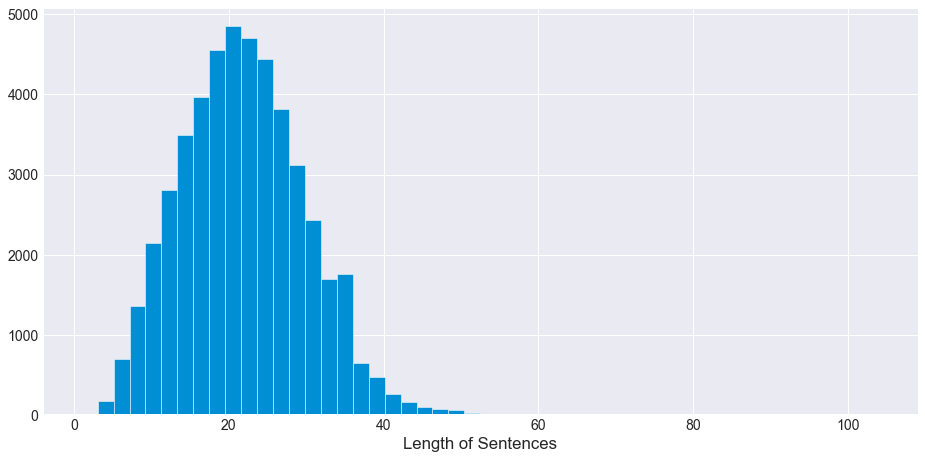

In [10]:
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(14,7))
plt.hist([len(s) for s in sentences],bins = 50)
plt.xlabel("Length of Sentences")
plt.show()

In [11]:
max_len = 50
tag2idx = {t: i for i, t in enumerate(tags)}

In [12]:
tag2idx

{'I-gpe': 0,
 'B-art': 1,
 'B-org': 2,
 'I-org': 3,
 'I-per': 4,
 'I-tim': 5,
 'I-nat': 6,
 'I-geo': 7,
 'B-nat': 8,
 'B-per': 9,
 'B-geo': 10,
 'I-eve': 11,
 'B-tim': 12,
 'I-art': 13,
 'B-gpe': 14,
 'B-eve': 15,
 'O': 16}

To apply the EMLo embedding from tensorflow hub, we have to use strings as input. So we take the tokenized sentences and pad them to the desired length.

In [13]:
X = [[w[0] for w in  s] for s in sentences]

In [14]:
new_X = []
for sent_sequence in X:
    new_sent_sequence = []
    for i in range(max_len):
        try:
            # append word on the sentence
            new_sent_sequence.append(sent_sequence[i])
        except:
            # If sequence is less than 50 tokens, add padding manually
            new_sent_sequence.append('__PAD__')
    new_X.append(new_sent_sequence)

In [15]:
new_X[2]

['Helicopter',
 'gunships',
 'Saturday',
 'pounded',
 'militant',
 'hideouts',
 'in',
 'the',
 'Orakzai',
 'tribal',
 'region',
 ',',
 'where',
 'many',
 'Taliban',
 'militants',
 'are',
 'believed',
 'to',
 'have',
 'fled',
 'to',
 'avoid',
 'an',
 'earlier',
 'military',
 'offensive',
 'in',
 'nearby',
 'South',
 'Waziristan',
 '.',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__']

we need to do the same for our tag sequence, but map the string to an integer.

In [16]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = tf.keras.preprocessing.sequence.pad_sequences(maxlen=max_len,sequences=y,padding='post',value=tag2idx['O'])

In [17]:
y[2]

array([16, 16, 12, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16,  2, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10,  7, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16])

In [18]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(new_X,y,test_size = 0.1,random_state = 42)

In [19]:
batch_size = 32

In [20]:
import tensorflow_hub as hub 
import tensorflow.compat.v1 as tf1
tf1.disable_eager_execution()
tf1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [21]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

from cachetools import TTLCache,cached
cache = TTLCache(maxsize=100, ttl=21600)

# @cached(cache)
# def ELMoEmbedding(x):
#     return elmo(tf.reshape(tf.cast(x,tf.string),[-1]),signature='default',as_dict=True)['elmo']
@cached(cache)
def ElmoEmbedding(x):
    return elmo(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [22]:
# len(X_train) // batch_size
N_batches = int(np.ceil(len(X_train) / batch_size))
N_batches

1349

In [23]:
## Model Architecture

# input text is a sequence of 50 tokens
def get_model(max_len=50):
    input_text = tf.keras.layers.Input(shape=(max_len,), dtype='string',name='input_text')
    embedding = tf.keras.layers.Lambda(ElmoEmbedding,output_shape = (None,max_len,1024), name = 'elmo_embedding')(input_text)

    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,return_sequences=True,recurrent_dropout=0.2,dropout=0.2))(embedding)
    x_rnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,return_sequences=True,recurrent_dropout=0.2,dropout=0.2))(x)

    #   residual connection
    x = tf.keras.layers.Add()([x,x_rnn])

    out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_tags,activation='softmax'))(x)

    model =tf.keras.models.Model(input_text,out)
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    return model

In [24]:
model=get_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [25]:

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
elmo_embedding (Lambda)         (32, None, 1024)     0           input_text[0][0]                 
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (32, None, 1024)     6295552     elmo_embedding[0][0]             
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (32, None, 1024)     6295552     bidirectional[0][0]              
_______________________________________________________________________________________

In [26]:
n_batches = len(X_train) // batch_size
n_batches

1348

In [27]:
print(f'Training Samples: {len(X_train)}')

Training Samples: 43163


As we have 43,163 samples and a batch size of 32, it is not directly divisible by 32 and processing the last batch ends in error.<br>
So, we have to take the samples such that each batch as exactly 32 samples to train on.

In [29]:
X_train, X_val = X_train[:1200*batch_size], X_train[-148*batch_size:]
y_train, y_val = y_train[:1200*batch_size], y_train[-148*batch_size:]

y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    sess.run(tf.compat.v1.tables_initializer())

    history = model.fit(np.array(X_train),y_train,epochs=2,validation_data=(np.array(X_val), y_val),batch_size = batch_size)
    model.save_weights('../Models/NER_ELMo_biLSTM.h5')

Train on 38400 samples, validate on 4736 samples
Epoch 1/2
38400/38400 [==============================] - ETA: 0s - loss: 0.0626 - acc: 0.9819WARNING:tensorflow:From C:\Users\Subha\.conda\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
38400/38400 [==============================] - 720s 19ms/sample - loss: 0.0626 - acc: 0.9819 - val_loss: 0.0481 - val_acc: 0.9852
Epoch 2/2
38400/38400 [==============================] - 718s 19ms/sample - loss: 0.0405 - acc: 0.9869 - val_loss: 0.0438 - val_acc: 0.9862


In [36]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


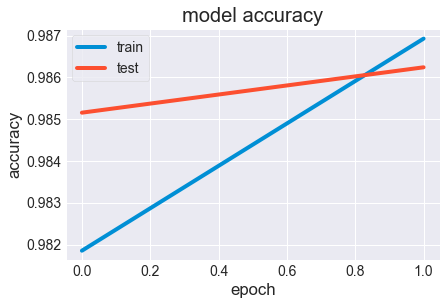

In [37]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

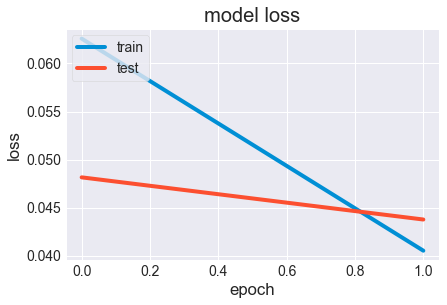

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Load Model and Inference

In [48]:
len(X_test) / 32

149.875

In [62]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    sess.run(tf.compat.v1.tables_initializer())
    model = get_model()
    model.load_weights('../Models/NER_ELMo_biLSTM.h5')

    i = 20
    preds = model.predict(np.array(X_test[i:i+batch_size]))[0]
    preds = np.argmax(preds, axis=-1)
    print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
    print("="*30)
    for w, true, pred in zip(X_test[i], y_test[i], preds):
        if w != "__PAD__":
            print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Word            Pred : (True)
The            :O     (O)
Dalai          :B-per (B-per)
Lama           :I-per (I-per)
signed         :O     (O)
up             :O     (O)
for            :O     (O)
his            :O     (O)
online         :O     (O)
account        :O     (O)
Monday         :B-tim (B-tim)
,              :O     (O)
a              :O     (O)
day            :O     (O)
after          :O     (O)
meeting        :O     (O)
Twitter        :B-org (B-org)
founder        :O     (O)
Evan           :B-per (B-per)
Williams       :I-per (I-per)
in             :O     (O)
Los            :B-geo (B-geo)
Angeles        :I-geo (I-geo)
,              :O     (O)
California     :B-geo (B-geo)
.              :O     (O)


In [95]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

X_test = X_test[:149*batch_size]
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    sess.run(tf.compat.v1.tables_initializer())
    model = get_model()
    model.load_weights('../Models/NER_ELMo_biLSTM.h5')
    test_pred = model.predict(np.array(X_test), verbose=1)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [96]:
idx2tag = {i: w for w, i in tag2idx.items()}

In [97]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("__PAD__", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("__PAD__", "O"))
        out.append(out_i)
    return out   

pred_labels = pred2label(test_pred)
test_labels = test2label(y_test[:149*32])   

In [98]:
len(pred_labels)

4768

In [99]:
len(test_labels)

4768

In [100]:
test_labels[1]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-org',
 'I-org',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [101]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 82.4%


In [102]:
from seqeval.metrics import precision_score,recall_score,f1_score,classification_report

print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

         art       0.50      0.11      0.18        45
         eve       0.22      0.23      0.22        35
         geo       0.83      0.91      0.87      3773
         gpe       0.97      0.92      0.95      1591
         nat       0.33      0.25      0.29        20
         org       0.72      0.63      0.67      2039
         per       0.74      0.81      0.77      1654
         tim       0.84      0.86      0.85      2025

   micro avg       0.82      0.83      0.82     11182
   macro avg       0.64      0.59      0.60     11182
weighted avg       0.82      0.83      0.82     11182



In [72]:
# import math
# class Generator(tf.keras.utils.Sequence):
#     # Class is a dataset wrapper for better training performance
#     def __init__(self, x_set, y_set, batch_size=32):
#         self.x, self.y = np.array(x_set), np.array(y_set)
#         self.n_samples = len(self.x)
#         self.batch_size = batch_size
#         self.indices = np.arange(self.n_samples)

#     def __len__(self):
#         return math.ceil(self.n_samples / self.batch_size)


#     def __getitem__(self, idx):
#         inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]  # Line A
#         batch_x = self.x[inds]
#         batch_y = self.y[inds]
#         return batch_x, batch_y

#     def on_epoch_end(self):
#         np.random.shuffle(self.indices)

# # train_data_gen = Generator(X_train, y_train)
# test_data_gen = Generator(X_test, y_test)

In [31]:
# with tf.compat.v1.Session() as sess:
#     sess.run(tf.compat.v1.global_variables_initializer())
#     sess.run(tf.compat.v1.tables_initializer())

#     history = model.fit(train_data_gen,epochs=1)
#     model.save_weights('../Models/NER_ELMo_biLSTM.h5')